# LAB 6

This lab is about advection diffusion problem.

Advection diffusion problem have stability issues, se we'll see those effects

In [ ]:
# Installation of firedrake
try:
  import firedrake
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  import firedrak

In [ ]:
# Installation of libraries for mesh on EX.2
!apt-get install -y libglu1-mesa
!pip install pygmsh gmsh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglu1-mesa is already the newest version (9.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## EXERCISE 1

Consider the domain $Ω = (0, 1) × (0, 1)$, and the PDE problem \\

$$
  \begin{cases}
    -μΔu + \boldsymbol{b}\cdot∇u = f \quad in \, Ω \\
    u = g_{D} \quad \quad on \, ∂Ω
  \end{cases}
$$ \\


where $µ = 10^{-2}$ and $b = [−1, −1]$. The exact solution is

$$
u(x,y) = \frac{e^{-\mu^{-1}x}-1}{e^{-\mu^{-1}}-1} + \frac{e^{-\mu^{-1}y}-1}{e^{-\mu^{-1}}-1}
$$ \\

(a) Compute $f$ and $g_D$ based on the provided exact solution. \\
(b) Write the weak form of the problem. \\
(c) Solve the problem using Firedrake and comment the obtained result. \\
(d) Implement streamwise diffusion, SUPG and GLS to stabilize the solver.

### (a) Compute $f$ and $g_D$ based on the provided exact solution.

To compute $f$ and $g_D$ starting from the exact solution $u$ we have that: \\

$$
f = -μΔu + \boldsymbol{b}∇u = -μ(\frac{∂^2u}{∂x^2}+\frac{∂^2u}{∂y^2}) + \boldsymbol{b}(\frac{∂u}{∂x}+\frac{∂u}{∂y})\\
$$ \\

Therefore, recalling $u(x,y) = \frac{e^{-\frac{1}{μ}x}-1}{e^{-\frac{1}{μ}}-1} + \frac{e^{-\frac{1}{μ}y}-1}{e^{-\frac{1}{μ}}-1}$, then: \\

$\frac{∂u}{∂x} = -\frac{1}{μ}\frac{e^{-\frac{1}{μ}x}}{e^{-\frac{1}{μ}}-1}$, $\quad$ $-\frac{1}{μ}\frac{e^{-\frac{1}{μ}y}}{e^{-\frac{1}{μ}}-1}$ \\

$\frac{∂^2u}{∂x^2} = \frac{1}{μ^2}\frac{e^{-\frac{1}{μ}x}}{e^{-\frac{1}{μ}}-1}$, $\quad$ $\frac{∂^2u}{∂y^2} = \frac{1}{μ^2}\frac{e^{-\frac{1}{μ}y}}{e^{-\frac{1}{μ}}-1}$ \\

So: \\

$$
f = - \mu\frac{1}{μ^2}\left(\frac{e^{-\frac{1}{μ}x}}{e^{-\frac{1}{μ}}-1}+\frac{e^{-\frac{1}{μ}y}}{e^{-\frac{1}{μ}}-1}\right) - \boldsymbol{b} \frac1\mu\left(\frac{e^{-\frac{1}{μ}x}}{e^{-\frac{1}{μ}}-1}+\frac{e^{-\frac{1}{μ}y}}{e^{-\frac{1}{μ}}-1}\right)
$$ \\

Then since $\boldsymbol{b} = [-1, -1]$ then: \\

$$
f =  - \frac{1}{μ}\left(\frac{e^{-\frac{1}{μ}x}}{e^{-\frac{1}{μ}}-1}+\frac{e^{-\frac{1}{μ}y}}{e^{-\frac{1}{μ}}-1}\right) + \frac1\mu\left(\frac{e^{-\frac{1}{μ}x}}{e^{-\frac{1}{μ}}-1}+\frac{e^{-\frac{1}{μ}y}}{e^{-\frac{1}{μ}}-1}\right) ⇒ f = 0
$$ \\

Instead $g_D$ is pretty straight forward and is: $ g_D = u|_{\partial \Omega}$.

### (b) Write the weak form of the problem.

The weak form of the above problem is: \\

$$
\int_{\Omega} (-μ \Delta u + \boldsymbol{b}⋅\boldsymbol{∇}u)v \, dx = \int_{\Omega} fv \, dx
$$

Now integrating by parts the first term of the integral: \\
$$
-μ \int_{\Omega} \Delta u v \, dx = -μ (\int_{\partial\Omega} \boldsymbol{∇}u \cdot \boldsymbol{n} v \, ds - \int_{\Omega} \boldsymbol{∇} u \cdot \boldsymbol{∇}v \, dx)
$$

Now, the boundary $\partial Ω$ can be divided into Newmann and Diriclet. Since this time we only have Diriclet, then the weak firmulation becomes: \\

$$
  \text{Find } u \in \{ v \in H^1(\Omega) \, : \, v|_{ \partial \Omega} = g_D\} \quad \text{ s. t. } \quad
  a(u,v) = L(v) \;
  \forall v \in H^1_0(\Omega),
$$ \\

where:
$$
a(u,v) :=  \int_\Omega \mu \boldsymbol{\nabla}u \cdot \boldsymbol{\nabla} v \, d\boldsymbol{x}+ \int_\Omega (\boldsymbol{b} \cdot\boldsymbol{\nabla} u) v \, d\boldsymbol{x}
$$ \\

and
$$
L(v) := \int_\Omega f v \, d\boldsymbol{x} \quad \text{where} \, f = 0 \, \, \text{in this case.}
$$

### (c) Solve the problem using Firedrake and comment the obtained result.

In [ ]:
from firedrake import *
import firedrake.pyplot as fdplt
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the mesh:
N = 10 # We use a small number of elements because we want to check instability
mesh = UnitSquareMesh(N, N)
x, y = SpatialCoordinate(mesh) # Get the spatial coordinates of the mesh


# Define the Function space
V = FunctionSpace(mesh, 'P', 1) # Defined as P1 elements


# Define data and exact solution (for Firedrake the constants has to be declared):
mu = Constant(1e-2)
b = Constant(as_vector((-1, -1)))
f = Constant(0.)
u_ex = (exp(-x/mu) + exp(-y/mu) - 2)/(exp(-1/mu) - 1) # Exact solution


# Define Diriclhet B.C.:
bc = DirichletBC(V, u_ex, 'on_boundary')


# Define test and trial functions:
u = TrialFunction(V)
v = TestFunction(V)


# Solve the weak formulation of the problem:
a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx # Bilinear form
L = f * v * dx # Linear function
u_h = Function(V) # Set the solution belonging to V-space
# Solve the problem:
solve(a==L, u_h, bcs=bc)


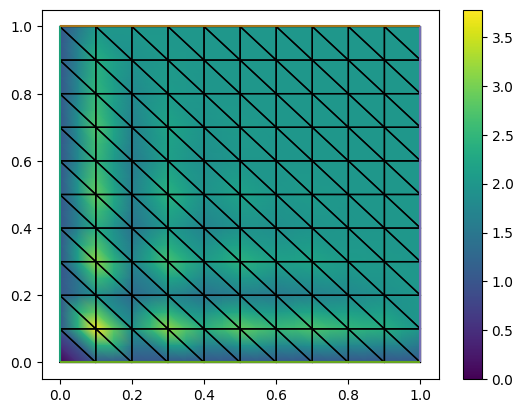

In [ ]:
fig, ax = plt.subplots()
q = fdplt.tripcolor(u_h, axes=ax)
fdplt.triplot(mesh, axes=ax)
plt.colorbar(q)

We notice that the solution is not accurate, it should infact represent a boundary layer in 2D  but instead is OSCILLATING. \\

The local Peclet number in fact should be less than one to have a good stable solution while in this case is $Pe_L = \frac{||b||_2h}{1μ}$

In [ ]:
h = (1-0)/N
b = np.array([-1,-1])
mu = 10**(-2)
Pe = (np.linalg.norm(b, ord=1)*h)/(2*mu)
print(f'The Peclet number is: Pe = ',Pe)

The Peclet number is: Pe =  10.0


### (d) Implement streamwise diffusion, SUPG and GLS to stabilize the solver.

#### **Streamline diffusion stabilization**

The **streamline diffusion stabilization** consists in modifying the bilinear form by adding the directional diffusion term:

$$
a_s(u_h,v_h) = \tau \int_\Omega (\boldsymbol{b} \cdot \boldsymbol{\nabla}u_h)
(\boldsymbol{b} \cdot \boldsymbol{\nabla}v_h)\, d\boldsymbol{x}
$$ \\

where

$$
\tau = \frac{\beta h}{2\|\boldsymbol{b}\|_2} \min\left\{1,\frac{\mathbb{P}e}3\right\},
$$ \\

with $\mathbb{P}e= \frac{\|\boldsymbol{b}\|_2h}{2\mu}$, the Peclét number, $h$ the diameter of the FE,
and $\beta \geq 0$ is an arbitrarily chosen parameter (the case $\beta=0$ corresponds to the usual FEM without stabilization). \\

Now we try to add viscosity to get better results.

In [ ]:
# Define the mesh:
N = 10 # We use a small number of elements because we want to check instability
mesh = UnitSquareMesh(N, N)
x, y = SpatialCoordinate(mesh) # Get the spatial coordinates of the mesh


# Define the Function space
V = FunctionSpace(mesh, 'P', 1) # Defined as P1 elements


# Define data and exact solution (for Firedrake the constants has to be declared):
mu = Constant(1e-2)
b = Constant(as_vector((-1, -1)))
f = Constant(0.)
u_ex = (exp(-x/mu) + exp(-y/mu) - 2)/(exp(-1/mu) - 1) # Exact solution


# Define Diriclhet B.C.:
bc = DirichletBC(V, u_ex, 'on_boundary')


# Define test and trial functions:
u = TrialFunction(V)
v = TestFunction(V)



# -------------- STABILIZATION: --------------
beta = 1 # Knob to tune the stabilization (remember beta>=0)
b_norm = sqrt(dot(b, b))
h = CellDiameter(mesh) # Function of firedrake to get h
Pe = b_norm*h/(2*mu)
tau = beta*h/(2*b_norm)*conditional(Pe/3>1, 1, Pe/3)

a_s = tau * dot(b, grad(u)) * dot(b, grad(v)) * dx # Stabilization a
# ---------------------------------------------


# Solve the weak formulation of the problem:
a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx # Bilinear form
L = f * v * dx # Linear function
u_h = Function(V) # Set the solution belonging to V-space
# Solve the problem:
solve(a+a_s==L, u_h, bcs=bc)


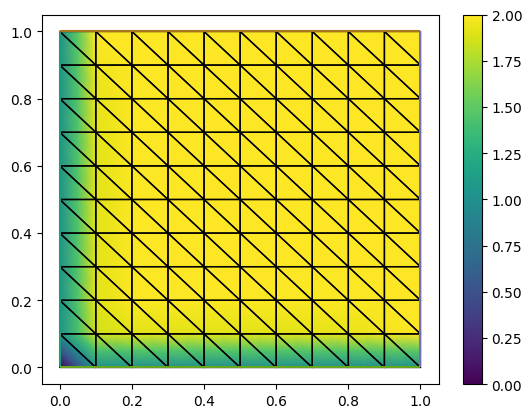

In [ ]:
fig, ax = plt.subplots()
q = fdplt.tripcolor(u_h, axes=ax)
fdplt.triplot(mesh, axes=ax)
plt.colorbar(q)

Now we're representing a good boundary layer, actually this is the best we can have because the mesh is about the same size as the boundary layer.

#### **Strongly consistent methods: SUPG and GLS**

The **strongly consistent methods SUPG and GLS** can be defined using the two functions: \\

$$
R(u) := - \mu \Delta u + \boldsymbol{b} \cdot\boldsymbol{\nabla} u - f
$$ \\

and
$$
P(v;\rho) := \rho( - \mu \Delta v ) + \boldsymbol{b} \cdot\boldsymbol{\nabla} v,
$$ \\

where $\rho=0$ leads to the SUPG method and $\rho=1$ to the GLS method.
Using these functions, the stabilization term to be added to the discrete bilinear form is: \\

$$
a_s(u_h,v_h;\rho) = \sum_E \int_E P(v_h;\rho) \tau R(u_h) \, d\boldsymbol{x},
$$ \\

where the stabilization parameter $\tau$ is chosen as before. Notice that: \\

- The stabilization term is written as the sum of elementwise integrals, because even in the case of higher order elements the continuity of derivatives is not guaranteed (you should use e.g. Hermite polynomials to obtain continuous derivatives; actually, the GLS term with the integral extended to the whole domain corresponds to the Least Squares FEM formulation, an alternative to the Galerkin FEM);
- When linear elements are chosen, these two methods coincide with streamline diffusion, since the laplacian is zero on each element;
- In our case we have $f=0$. When $f \neq 0$, the term containing $f$ in $c$ is part of the right hand side, and not of the bilinear form (as it is actually a linear functional in $v$!)

Therefore your code can be implemented as follow:

In [ ]:
# Define the mesh:
N = 10 # We use a small number of elements because we want to check instability
mesh = UnitSquareMesh(N, N)
x, y = SpatialCoordinate(mesh) # Get the spatial coordinates of the mesh


# Define the Function space
V = FunctionSpace(mesh, 'P', 1) # Defined as P1 elements


# Define data and exact solution (for Firedrake the constants has to be declared):
mu = Constant(1e-2)
b = Constant(as_vector((-1, -1)))
f = Constant(0.)
u_ex = (exp(-x/mu) + exp(-y/mu) - 2)/(exp(-1/mu) - 1) # Exact solution


# Define Diriclhet B.C.:
bc = DirichletBC(V, u_ex, 'on_boundary')


# Define test and trial functions:
u = TrialFunction(V)
v = TestFunction(V)



# ---------------------------- STABILIZATION: ----------------------------
beta = 1 # Knob to tune the stabilization (remember beta>=0)
b_norm = sqrt(dot(b, b))
h = CellDiameter(mesh) # Function of firedrake to get h
Pe = b_norm*h/(2*mu)
tau = beta*h/(2*b_norm)*conditional(Pe/3>1, 1, Pe/3)

# a_s = uau * dot(b, grad(u)) * dot(b, grad(v)) * dx # Stabilization a


# -------------- STRONGLY CONSISTENT methods: --------------
rho = 0 # Method SUPG
# rho = 1 # Method GLS
R = -mu*div(grad(u))+dot(b, grad(u))
P = rho*(-mu*div(grad(v))) + (dot(b, grad(v)))

a_s = tau * R * P * dx
# ----------------------------------------------------------
# -----------------------------------------------------------------------


# Solve the weak formulation of the problem:
a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx # Bilinear form
L = f * v * dx # Linear function
u_h = Function(V) # Set the solution belonging to V-space
# Solve the problem:
solve(a+a_s==L, u_h, bcs=bc)


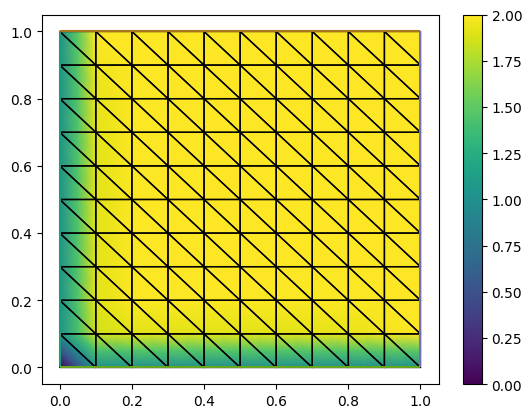

In [ ]:
fig, ax = plt.subplots()
q = fdplt.tripcolor(u_h, axes=ax)
fdplt.triplot(mesh, axes=ax)
plt.colorbar(q)

## EXERCISE 2

File Lab 6 - ex2.ipynb contains the construction of the mesh of a room. Boundary 1 is an AC
vent, sending air into the room. Boundary 2 is an area where a gas leak is happening. Boundary
3 is an open window. Boundary 4 are the walls of the room. \\

We approximately solve the problem of determining the steady-state concentration of gas in the
room by performing two steps: compute the airflow in the room, assuming potential flow; use the
airflow as an advection field for the gas concentration. \\

\\

(a) Write the weak formulation of \\

$$
  \begin{cases}
    Δ\phi = 0 \quad \quad \text{in }Ω \\
    ∇\phi⋅n = 0 \quad \quad \text{on }Γ_2 \cup Γ_4 \\
    ∇\phi⋅n = -1 \quad \quad \text{on }Γ_1 \\
    ∇\phi⋅n = 1 \quad \quad \text{on }Γ_3 \\
  \end{cases}
$$ \\

and solve it using Firedrake. Notice that the problem is not well-posed (solutions are defined
up to a constant), but we do not care about constants, since we only need the flow field that
is the gradient of ϕ. See https://www.firedrakeproject.org/solving-interface.html#
solving-singular-systems for how to solve a singular system in Firedrake. \\

(b) Write the weak formulation of \\

$$
  \begin{cases}
    -μΔu + \boldsymbol{b}\cdot ∇u = 0 \quad in \, Ω \\
    ∇u \cdot \boldsymbol{n} = 0 \quad \quad on \, ∂Ω \, \, \text{without } Γ_2 \\
    u = 1 \quad \quad on \, Γ_2
  \end{cases}
$$ \\

and solve it using Firedrake using $b = a∇ϕ$, where a is $a$ parameter that allows us to adjust
the strength of the velocity field after its computation for unit boundary conditions. This is
possible thanks to linearity. Plot the solution and comment it.

### a) Write the weak formulation of the potential and solve it using Firedrake

#### Weak Formulation of the potential:

For the *Weak formulation* we multiply the equation by a test
function $v$ and we integrate over the domain $\Omega$ to obtain: \\

\begin{equation*}
  \int_\Omega Δ\phi v \,
  \mathrm{d\Omega} = 0
\end{equation*}

\\

Now integrating by parts: \\

\\

\begin{equation*}
  ⇒\int_{\partial\Omega} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma} -
  \int_\Omega \boldsymbol{\nabla} \phi\cdot \boldsymbol{\nabla} v \, \mathrm{d\Omega} =0
\end{equation*}

\\

The **integral over the boundary $\partial\Omega$ is split into four contributions**: \\

\\

\begin{equation*}
  \int_{\partial\Omega} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma} = \int_{\Gamma_1} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma_1} + \int_{\Gamma_2} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma_2} + \int_{\Gamma_3} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma_3} + \int_{\Gamma_4} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma_4} = \int_{\Gamma_2\cup\Gamma_4} (0) v \, \mathrm{d\Gamma_24} + \int_{\Gamma_1} (-1) v \, \mathrm{d\Gamma_1} + \int_{\Gamma_3} (1) v \, \mathrm{d\Gamma_3} \\
  ⇒ \int_{\partial\Omega} (\boldsymbol{\nabla} \phi \cdot{\boldsymbol{n}}) v \, \mathrm{d\Gamma} = - \int_{\Gamma_1} v \, \mathrm{d\Gamma_1} + \int_{\Gamma_3} v \, \mathrm{d\Gamma_3}
\end{equation*} \\

\\

Therefore the **weak formulation** reads:

$$
\text{Find } \phi \in H^1(\Omega) \;\text{ satisfying the essential b.c.s and such that } \; a(\phi, v) = L(v) \quad \forall \, v\in H^1_{0,\Gamma_D}(\Omega),
$$ \\

where: \\

\begin{equation*}
  a(\phi, v) = \int_\Omega \boldsymbol{\nabla} \phi\cdot \boldsymbol{\nabla} v \, \mathrm{d\Omega}
\end{equation*} \\

and \\

\begin{equation*}
  L(v) = -\int_{\Gamma_1} v \, \mathrm{d\Gamma_1} + \int_{\Gamma_3} v \, \mathrm{d\Gamma_3}
\end{equation*}

\\

#### Solve the potential probelm using Firedrake

We approximately solve the problem of determining the steady-state concentration of gas in the room by performing two steps, where the first is this one and we need to compute the airflow in the room, assuming potential flow. \\

Thus, we solve: \\

$$
\begin{cases}
\Delta \phi = 0 & \text{in $\Omega$} \\
\nabla \phi \cdot \mathbf{n} = 0 & \text{on $\Gamma_2 \cup \Gamma_4$}\\
\nabla \phi \cdot \mathbf{n} = -1 & \text{on $\Gamma_1$}\\
\nabla \phi \cdot \mathbf{n} = 1 & \text{on $\Gamma_3$}\\
\end{cases}
$$

In [ ]:
# IMPORT GEOMETRY (given by the professor)
import pygmsh
import gmsh
with pygmsh.geo.Geometry() as geom:
    h = 0.1
    p1 = geom.add_point([0.0, 0.0], h)
    p2 = geom.add_point([3.0, 0.0], h)
    p3 = geom.add_point([4.0, 0.0], h)
    p4 = geom.add_point([5.0, 0.0], h)
    p5 = geom.add_point([5.0, 5.0], h)
    p6 = geom.add_point([3.0, 4.2], h)
    p7 = geom.add_point([2.0, 3.8], h)
    p8 = geom.add_point([0.0, 3.0], h)
    p9 = geom.add_point([0.0, 2.0], h)
    p10 = geom.add_point([0.0, 1.0], h)
    # lines
    l1 = geom.add_line(p1, p2)
    l2 = geom.add_line(p2, p3)
    l3 = geom.add_line(p3, p4)
    l4 = geom.add_line(p4, p5)
    l5 = geom.add_line(p5, p6)
    l6 = geom.add_line(p6, p7)
    l7 = geom.add_line(p7, p8)
    l8 = geom.add_line(p8, p9)
    l9 = geom.add_line(p9, p10)
    l10 = geom.add_line(p10, p1)
    boundary = geom.add_curve_loop([l1, l2, l3, l4, l5,
                                    l6, l7, l8, l9, l10])
    # surface
    pl = geom.add_plane_surface(boundary)
    # boundary tags
    geom.add_physical([l2], 'ac')
    geom.add_physical([l6], 'leak')
    geom.add_physical([l9], 'window')
    geom.add_physical([l1, l3, l4, l5, l7, l8, l10], 'walls')
    geom.add_physical([pl], 'domain')
    mesh = geom.generate_mesh()

    gmsh.write("room.msh")
    gmsh.write("room.vtk")

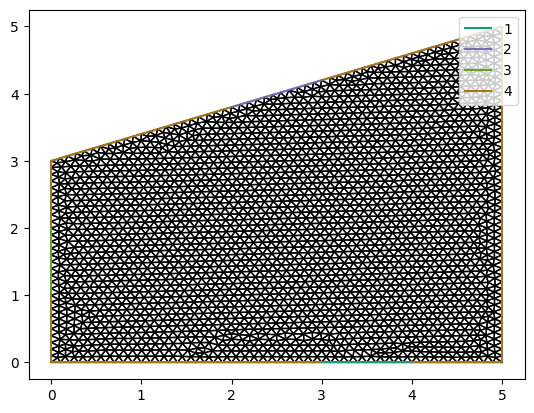

In [ ]:
mesh = Mesh('room.msh')

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend()

The one above is the mesh of a room. \\

*   Boundary 1 is an AC vent, sending air into the room.
*   Boundary 2 is an area where a gas leak is happening.
*   Boundary 3 is an open window.
*   Boundary 4 are the walls of the room. \\



In [ ]:
# Compute phi_h, the solution of the Laplace equation
# Define the function space
V = FunctionSpace(mesh, "CG", 1)


# Define trial and test functions as belonging to the space
phi = TrialFunction(V) # Trial function
v = TestFunction(V) # Test function


# We do not have Boundary Conditions (problem NOT well posed)
nullspace = VectorSpaceBasis(constant=True)


# Define the variational problem:
a = dot(grad(phi), grad(v))*dx # Bilinear form
L = - v * ds(1) + v * ds(3)

# Get the approximate solution
phi_h = Function(V)
solve(a==L, phi_h, nullspace=nullspace)



firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


### b) Write the weak formulation of the advection-diffusion problem and solve it using Firedrake

#### Weak formulation of advection-diffusion

The weak form of the above problem is: \\

$$
\int_{\Omega} (-μ \Delta u + \boldsymbol{b}⋅\boldsymbol{∇}u)v \, dx = \int_{\Omega} fv \, dx
$$

Now integrating by parts the first term of the integral: \\
$$
-μ \int_{\Omega} \Delta u v \, dx = -μ (\int_{\partial\Omega} \boldsymbol{∇}u \cdot \boldsymbol{n} v \, ds - \int_{\Omega} \boldsymbol{∇} u \cdot \boldsymbol{∇}v \, dx)
$$

Now, the boundary $\partial Ω$ can be divided into Newmann and Diriclet. Since this time Newmann is zero, then the weak firmulation becomes: \\

$$
  \text{Find } u \in \{ v \in H^1(\Omega) \, : \, v|_{ \Gamma_2} = 1\} \quad \text{ s. t. } \quad
  a(u,v) = L(v) \;
  \forall v \in H^1_0(\Omega),
$$ \\

where:
$$
a(u,v) :=  \mu \int_\Omega  \boldsymbol{\nabla}u \cdot \boldsymbol{\nabla} v \, d\boldsymbol{x} + \int_\Omega (\boldsymbol{b} \cdot\boldsymbol{\nabla} u) v \, d\boldsymbol{x}
$$ \\

and
$$
L(v) := \int_\Omega f v \, d\boldsymbol{x} \quad \text{where} \, f = 0 \, \, \text{in this case.}
$$

#### Solution of advection-diffusion with Firedrake

Now we use the airflow as an advection field for the gas concentration. \\
We are interested only in the velocity field $\mathbf{b} = a \nabla \phi$, where
$a$ is a parameter that allows us to adjust the strength of the velocity field after its computation for unit boundary conditions. This is possible thanks to linearity. \\

So, we solve: \\

$$
\begin{cases}
-\mu \Delta u + \mathbf{b} \cdot \nabla u = 0 & \text{in $\Omega$} \\
\nabla u \cdot \mathbf{n} = 0 & \text{on $\partial \Omega \setminus \Gamma_2$}\\
u = 1 & \text{on $\Gamma_2$}
\end{cases}
$$

In [ ]:
def solve_strong_cons(mesh, degree, mu, f, delta, rho, airflow):

  # Define the Function space
  V = FunctionSpace(mesh, "P", 1)


  # Define Diriclhet B.C.:
  bc = DirichletBC(V, Constant(1.), 2)


  # Define test and trial functions:
  u = TrialFunction(V)
  v = TestFunction(V)


  # Set b and f:
  VV = VectorFunctionSpace(mesh, "P", 1)
  grad_phi_h = project(grad(phi_h), VV)
  b = airflow * grad_phi_h
  f = Constant(0.)


  # Solve the weak formulation of the problem:
  a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx # Bilinear form
  L = f * v * dx  # Linear function
  u_h = Function(V) # Set the solution belonging to V-space
  # Solve the problem:
  solve(a==L, u_h, bcs=bc)

  return u_h, b

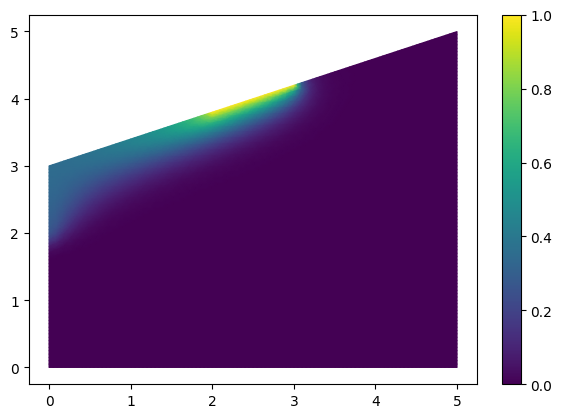

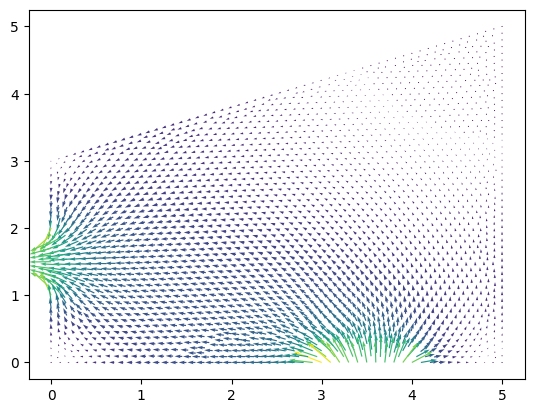

In [ ]:
degree = 1
airflow = 0.1
f = Constant(0.)
rho = Constant(1.0)
delta = 1.
mu = Constant(1e-3)


u_h, b = solve_strong_cons(mesh, degree, mu, f, delta, rho, airflow)


fig, ax = plt.subplots()
q = tripcolor(u_h, axes=ax)
plt.colorbar(q, fraction=0.045)
fig, ax = plt.subplots()
quiver(b, axes=ax)

## EXERCISE 3

Consider the problem

$$
  \begin{cases}
    -μΔu + \boldsymbol{b}\cdot ∇u = f \quad \text{in} \, Ω \\
    u = 0 \quad \quad \quad \quad \quad \quad \text{on} \, \partial Ω
  \end{cases}
$$ \\

where $µ = 10^{−3}$, $b = [3, 1]$, and $f=1$. \\

(a) Write the weak formulation of the problem. \\
(b) Solve the problem using Firedrake and plot the solution. \\
(c) Implement GLS stabilization.

### (a) Write the weak formulation of the problem.

The weak form of the above problem is: \\

$$
\int_{\Omega} (-μ \Delta u + \boldsymbol{b}⋅\boldsymbol{∇}u)v \, dx = \int_{\Omega} fv \, dx
$$

Now integrating by parts the first term of the integral: \\
$$
-μ \int_{\Omega} \Delta u v \, dx = -μ (\int_{\partial\Omega} \boldsymbol{∇}u \cdot \boldsymbol{n} v \, ds - \int_{\Omega} \boldsymbol{∇} u \cdot \boldsymbol{∇}v \, dx)
$$

Now, the boundary $\partial Ω$ can be divided into Newmann and Diriclet. Since this time we only have Diriclet, then the weak firmulation becomes: \\

$$
  \text{Find } u \in \{ v \in H^1(\Omega) \, : \, v|_{ \partial \Omega} = 0\} \quad \text{ s. t. } \quad
  a(u,v) = L(v) \;
  \forall v \in H^1_0(\Omega),
$$ \\

where:
$$
a(u,v) :=  \int_\Omega \mu \boldsymbol{\nabla}u \cdot \boldsymbol{\nabla} v \, d\boldsymbol{x}+ \int_\Omega (\boldsymbol{b} \cdot\boldsymbol{\nabla} u) v \, d\boldsymbol{x}
$$ \\

and
$$
L(v) := \int_\Omega f v \, d\boldsymbol{x} \quad \text{where} \, f = 1 \, \, \text{in this case.}
$$

### (b) Solve the problem using Firedrake and plot the solution.

In [ ]:
# Define the mesh:
N = 10 # We use a small number of elements because we want to check instability
mesh = UnitSquareMesh(N, N)
x, y = SpatialCoordinate(mesh) # Get the spatial coordinates of the mesh


# Define the Function space
V = FunctionSpace(mesh, 'P', 1) # Defined as P1 elements


# Define data and exact solution (for Firedrake the constants has to be declared):
mu = Constant(1e-3)
b = Constant(as_vector((3, 1)))
f = Constant(1.)


# Define Diriclhet B.C.:
bc = DirichletBC(V, 0, 'on_boundary')


# Define test and trial functions:
u = TrialFunction(V)
v = TestFunction(V)


# Solve the weak formulation of the problem:
a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx # Bilinear form
L = f * v * dx # Linear function
u_h = Function(V) # Set the solution belonging to V-space
# Solve the problem:
solve(a==L, u_h, bcs=bc)


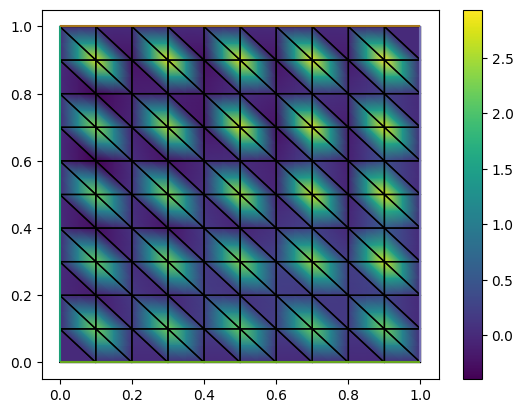

In [ ]:
fig, ax = plt.subplots()
q = fdplt.tripcolor(u_h, axes=ax)
fdplt.triplot(mesh, axes=ax)
plt.colorbar(q)

The solution is not stable, in fact we can look at the Peclet number and see that is:

In [ ]:
h = (1-0)/N
b = np.array([-1,-1])
mu = 10**(-2)
Pe = (np.linalg.norm(b, ord=1)*h)/(2*mu)
print(f'The Peclet number is: Pe = ',Pe)

The Peclet number is: Pe =  10.0


### (c) Implement GLS stabilization.

In [ ]:
# Define the mesh:
N = 10 # We use a small number of elements because we want to check instability
mesh = UnitSquareMesh(N, N)
x, y = SpatialCoordinate(mesh) # Get the spatial coordinates of the mesh


# Define the Function space
V = FunctionSpace(mesh, 'P', 1) # Defined as P1 elements


# Define data and exact solution (for Firedrake the constants has to be declared):
mu = Constant(1e-3)
b = Constant(as_vector((3, 1)))
f = Constant(1.)


# Define Diriclhet B.C.:
bc = DirichletBC(V, 0, 'on_boundary')


# Define test and trial functions:
u = TrialFunction(V)
v = TestFunction(V)



# ---------------------------- STABILIZATION: ----------------------------
beta = 1 # Knob to tune the stabilization (remember beta>=0)
b_norm = sqrt(dot(b, b))
h = CellDiameter(mesh) # Function of firedrake to get h
Pe = b_norm*h/(2*mu)
tau = beta*h/(2*b_norm)*conditional(Pe/3>1, 1, Pe/3)

# a_s = uau * dot(b, grad(u)) * dot(b, grad(v)) * dx # Stabilization a


# -------------- STRONGLY CONSISTENT methods: --------------
rho = 1 # Method GLS
R = -mu*div(grad(u))+dot(b, grad(u))
P = rho*(-mu*div(grad(v))) + (dot(b, grad(v)))

a_s = tau * R * P * dx
# ----------------------------------------------------------
# -----------------------------------------------------------------------


# Solve the weak formulation of the problem:
a = mu * dot(grad(u), grad(v)) * dx + dot(b, grad(u)) * v * dx # Bilinear form
L = f * v * dx # Linear function
u_h = Function(V) # Set the solution belonging to V-space
# Solve the problem:
solve(a+a_s==L, u_h, bcs=bc)


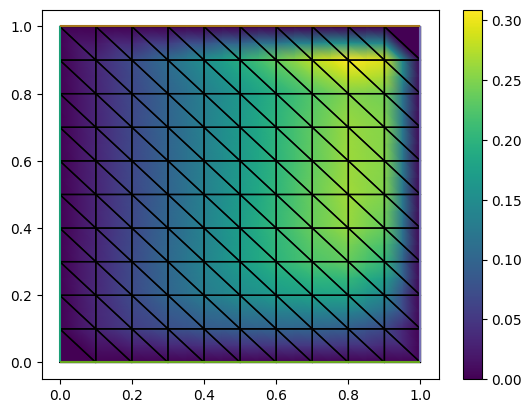

In [ ]:
fig, ax = plt.subplots()
q = fdplt.tripcolor(u_h, axes=ax)
fdplt.triplot(mesh, axes=ax)
plt.colorbar(q)